In [1]:
#import neccessary libraries
import numpy as np
import evaluation as ev
import csv
import pandas as pd

In [2]:
#set root file name
root_file = 'Gamma-E10-n1000-part2'

In [3]:
#read noise distribution of desired particle to do energy resolution on for a given energy level
df = pd.read_csv('cluster-noise-distribution_'+root_file+'.csv')

In [4]:
#set run parameters
n_events = 1000
noise = df['noise'][df['n_clusters_mean'].idxmin()]
cluster_n = 1

In [5]:
#modifiedtest_single_photon function (taken from test_stats.py) that returns cluster per hit & energy per hit
#this function calls our model and tests it using the root file defined in datasets.py in the single_photon_dataset function
def clusters_info_t(n_events, noise):
    tbeta = .2
    td = .5
    nmax = n_events
    yielder = ev.TestYielderSinglePhoton()
    yielder.model.signal_threshold = noise
    event_n_t = []
    event_cluster_t = []
    cluster_energy_t = []
    cluster_nhits_t = []
    for i, (event, prediction, clustering) in enumerate(yielder.iter_clustering(tbeta, td, nmax=nmax)):
        #see https://stackoverflow.com/questions/67108215/how-to-get-sum-of-values-in-a-numpy-array-based-on-another-array-with-repetitive
        np.set_printoptions(suppress=True) #suppress scientific notation

        #get true cluster energy
        _, idy, _ = np.unique(event.y, return_counts=True, return_inverse=True)
        energy_values_t = np.round(np.bincount(idy, event.energy),3)

        #get true clusters and get their total energy & hits
        event_cluster_unique_t, n_hits_t = np.unique(event.y, return_counts=True, return_index=False)
        event_i_t = np.full(len(event_cluster_unique_t), i, dtype=int)
        event_n_t = np.append(event_n_t, event_i_t)
        event_cluster_t = np.append(event_cluster_t, event_cluster_unique_t)
        cluster_nhits_t = np.append(cluster_nhits_t, n_hits_t)
        cluster_energy_t = np.append(cluster_energy_t, energy_values_t)
    return event_n_t, event_cluster_t, cluster_nhits_t, cluster_energy_t

In [6]:
#get truth clusters info
ci_t = clusters_info_t(n_events, noise)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:28<00:00,  4.80it/s]


In [7]:
#create pandas dataframe with results from cluster info
df_ci_t = pd.DataFrame({'event_n': ci_t[0].astype(np.int64), 'cluster_count': ci_t[1].astype(np.int64), 'n_hits_t': ci_t[2].astype(np.int64), 'energy_value_t': ci_t[3]})
df_ci_t

,event_n,cluster_count,n_hits_t,energy_value_t
0,0,0,17867,143.819
1,0,1,180,10.478
2,1,0,17931,143.481
3,1,1,148,9.306
4,2,0,18146,145.046
...,...,...,...,...
1995,997,1,142,10.516
1996,998,0,18033,145.365
1997,998,1,200,10.352
1998,999,0,17918,143.167


In [8]:
#write cluster info dataframe to .csv 
df_ci_t.to_csv('cluster-info-truth_'+root_file+'_noise-'+str(noise)+'.csv', index=False)

In [9]:
#calculate percentage of energy by cluster, per event
df_ci_t['energy_percentage_t'] = df_ci_t['energy_value_t'] / df_ci_t.groupby('event_n')['energy_value_t'].transform('sum')
df_ci_t

,event_n,cluster_count,n_hits_t,energy_value_t,energy_percentage_t
0,0,0,17867,143.819,0.932092
1,0,1,180,10.478,0.067908
2,1,0,17931,143.481,0.939092
3,1,1,148,9.306,0.060908
4,2,0,18146,145.046,0.943254
...,...,...,...,...,...
1995,997,1,142,10.516,0.068282
1996,998,0,18033,145.365,0.933520
1997,998,1,200,10.352,0.066480
1998,999,0,17918,143.167,0.934462


In [10]:
#get reco cluster info dataframe
df_ci = pd.read_csv('cluster-info_'+root_file+'_noise-'+str(noise)+'.csv')
df_ci

,event_n,clusterindex,n_hits,energy_value,energy_percentage,cluster_count
0,0,0,17882,143.975,0.933103,0
1,0,9,165,10.322,0.066897,1
2,1,0,17935,143.538,0.939465,0
3,1,26,144,9.249,0.060535,1
4,2,0,18150,145.097,0.943585,0
...,...,...,...,...,...,...
2200,997,47,131,10.403,0.067548,1
2201,998,0,18058,145.614,0.935119,0
2202,998,21,175,10.103,0.064881,1
2203,999,0,17924,143.265,0.935101,0


In [11]:
#merge dataframes based on cluster_count and keep only main signal cluster
df_r = pd.merge(df_ci_t, df_ci, on=['event_n','cluster_count'], how='outer')
df_r = df_r[df_r['cluster_count']==cluster_n]
df_r = df_r.reset_index(drop=True)

In [12]:
#calculate cluster response as E_reco/E_gen
df_r['cluster_response'] = np.round(df_r['energy_value']/df_r['energy_value_t'],6)
df_r

,event_n,cluster_count,n_hits_t,energy_value_t,energy_percentage_t,clusterindex,n_hits,energy_value,energy_percentage,cluster_response
0,0,1,180.0,10.478,0.067908,9.0,165.0,10.322,0.066897,0.985112
1,1,1,148.0,9.306,0.060908,26.0,144.0,9.249,0.060535,0.993875
2,2,1,124.0,8.726,0.056746,14.0,120.0,8.675,0.056415,0.994155
3,3,1,129.0,10.024,0.064169,25.0,123.0,9.873,0.063202,0.984936
4,4,1,135.0,10.474,0.067829,18.0,131.0,10.411,0.067421,0.993985
...,...,...,...,...,...,...,...,...,...,...
995,995,1,152.0,10.690,0.069239,26.0,134.0,10.344,0.066998,0.967633
996,996,1,140.0,10.711,0.069932,27.0,137.0,10.672,0.069677,0.996359
997,997,1,142.0,10.516,0.068282,47.0,131.0,10.403,0.067548,0.989254
998,998,1,200.0,10.352,0.066480,21.0,175.0,10.103,0.064881,0.975947


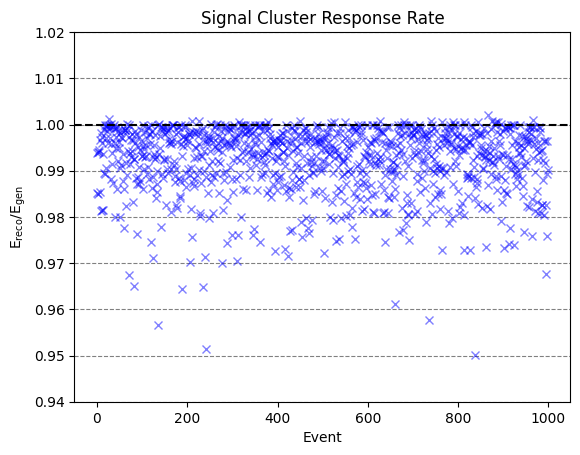

In [14]:
#set y-axis limits so that response is symmetric
ymin = np.round(df_r['cluster_response'][df_r['cluster_response'].idxmin()],2)-0.01
ymax = 1.02

ax = df_r.plot(x='event_n', 
               y='cluster_response',
               title = 'Signal Cluster Response Rate',
               ylabel = '$\mathregular{E_{reco}/E_{gen}}$', 
               xlabel =  'Event',
               style='x',
               color='blue',
               legend = None,
               alpha=0.5)

ax.axhline(1.0, color='k', linestyle='--', label='_nolabel_')

ax.set_ylim([ymin, ymax]) #uncomment for centered response

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.get_figure().savefig('cluster_response_rate-'+root_file+'_noise-'+str(noise)+'_signal' + str(cluster_n) +'.png', bbox_inches = 'tight')